# <CENTER> Разведывательный анализ данных
    
## <CENTER> Предсказание рейтинга отеля

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

In [222]:
import numpy as np 
import pandas as pd 
from datetime import date


import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder



from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 
from sklearn.feature_selection import f_classif


from sklearn.ensemble import RandomForestRegressor 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nataliatureva/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [223]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [224]:
# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv.zip') # самбмишн

In [225]:
#Давайте познакомимся с нашими данными:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [226]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [227]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


**Расшифровка признаков:**

- hotel_address — адрес отеля;

- review_date — дата, когда рецензент разместил соответствующий отзыв;

- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

- hotel_name — название отеля;

- reviewer_nationality — страна рецензента;

- negative_review — отрицательный отзыв, который рецензент дал отелю;

- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

- positive_review — положительный отзыв, который рецензент дал отелю;

- review_total_positive_word_counts — общее количество слов в положительном отзыве.

- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

- total_number_of_reviews — общее количество действительных отзывов об отеле;

- tags — теги, которые рецензент дал отелю;

- days_since_review — количество дней между датой проверки и датой очистки;

- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

- lat — географическая широта отеля;

- lng — географическая долгота отеля.

**Вывод: Как мы видим в тестовом датасете остутствует ключевой признак ['reviewer_score '], который для нас важен. Он есть в данных sample_submission и будет являтся показателем успешности нашей модели**

In [228]:
#ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

**Выводы:
В нашем датасете 10 числовых принаков и 8 признаков типа 'object'.
Также есть два признака с пропусками. Это ['lat'] и ['lng']. 
Заменить средним значением значением эти пропуски мы не можем, тк это широта и долгота и потеряется смысл в них. Поэтому мы их удалим из нашего анализа.**



# 2.EDA

Т.к. для обучения модели необходимы только числовые признаки, то давайте разберемся с  признаками  типо 'object' по порядку.

In [229]:
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

# 2.1 Признак `['hotel_address']`

In [230]:
df['hotel_address'].head(3)

0                   Via Senigallia 6 20161 Milan Italy
1    Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2          Mallorca 251 Eixample 08008 Barcelona Spain
Name: hotel_address, dtype: object

В данном признаке есть и адрес, и город, и страна. Создадим два новых признака: город ['city'] и страна ['country']

In [231]:
df['city']=df['hotel_address'].apply(lambda x: 'London' if x.split()[-1] == 'Kingdom' else x.split(' ')[-2])

In [232]:
df['country']=df['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])


Посмотрим что получилось:

In [233]:
display(df['country'].value_counts(), df['city'].value_counts())

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

Для дальнейшей работы закодируем эти признаки. Для кодирования будем использовать One-hot Encoding

In [234]:
#Импортируем необходимый модуль
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True)
type_bin = encoder.fit_transform(df['country'])
df = pd.concat([df, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True)
type_bin = encoder.fit_transform(df['city'])
df = pd.concat([df, type_bin], axis=1)

Теперь признак `['hotel_address']` нам больше не нужен. Удалим его

In [235]:
df= df.drop(['hotel_address'], axis=1)

# 2.2 Признак `['review_date']`

In [236]:
#Посмотрим что он из себя представляет:
df['review_date'].head(3)

0     7/21/2017
1    12/12/2016
2    11/26/2015
Name: review_date, dtype: object

Создадим отдельных два признака: месяц  ['month']и год ['year']:

In [237]:
#приведем признак к формату datetime:
df['review_date'] = pd.to_datetime(df['review_date'], format='%m/%d/%Y')

df['month'] = df['review_date'].dt.month.astype(int)
df['year'] = df['review_date'].dt.year.astype(int)

Теперь признак `['review_date']` нам больше не нужен. Удалим его

In [238]:
df = df.drop(['review_date'], axis=1)

# 2.3 Признак `['hotel_name']`

In [239]:
#Посмотрим сколько отелей представлено в рейтинге:
df['hotel_name'].nunique()

1492

Т.к. это слишком большое значение для кодирования, и никакой полезной информации он нам не принесет, поэтому мы просто удалим этот признак:

In [240]:
df = df.drop(['hotel_name'], axis=1)

# 2.4 Признак `['reviewer_nationality']`

In [241]:
#Посмотрим что из себя представляет признак:
df['reviewer_nationality'].head()

0               United Kingdom 
1                      Belgium 
2                       Sweden 
3     United States of America 
4               United Kingdom 
Name: reviewer_nationality, dtype: object

In [242]:
#Посмотрим сколько всего национальностей :
df['reviewer_nationality'].nunique()

227

Тоже слишком большое количество для кодирования и это не даст нам никакой полезной информации. Можно конечно выделить ТОП-10, а остальные поместить в категорию 'others', но я считаю что это будет слишком обобщенно. Удалим этот признак:

In [243]:
df = df.drop(['reviewer_nationality'], axis=1)

# 2.5 Признак `['negative_review']`

In [244]:
df['negative_review'].head(10)

0     Would have appreciated a shop in the hotel th...
1          No tissue paper box was present at the room
2                                             Pillows 
3                                          No Negative
4                                          No Negative
5                            They don t have free wifi
6     Room generally a bit shabby with some lack of...
7     Executive rooms 9th Floor don t have a bath T...
8                      Pity about the two days of rain
9     Didn t like it at all construction was in pro...
Name: negative_review, dtype: object

In [245]:
df['negative_review'].value_counts()[:20]

No Negative         127890
 Nothing             14295
 Nothing              4236
 nothing              2225
 N A                  1037
 None                  984
                       849
 N a                   509
 Breakfast             407
 Small room            373
 Location              368
 Everything            326
 All good              318
 Nothing really        316
 none                  302
 nothing               283
 No complaints         274
 Price                 260
 Nothing really        254
 Nil                   247
Name: negative_review, dtype: int64

Очень забавно, что в этот признак попададают комментарии 'No Negative' и их большинство, поэтому просто удалить их было бы неправильно.

In [246]:
#Создадим список самых частых ложных негативных отзывов:
negative_false = ['No Negative', 'Nothing']
#Заменяю негативные на 1, если позитивный - 0
df['new_negative_review'] = df['negative_review'].apply(lambda x: 0 if x in negative_false else 1)
#Посмотрим что теперь получилось?
df['new_negative_review'].value_counts()[:20]

1    387848
0    127890
Name: new_negative_review, dtype: int64

# 2.6 Признак `['positive_review']`

In [247]:
df['positive_review'].head(10)

0     Hotel was great clean friendly staff free bre...
1                                          No Positive
2                           Nice welcoming and service
3     Everything including the nice upgrade The Hot...
4                      Lovely hotel v welcoming staff 
5     The location is perfect if you don t have a l...
6     Location price It did not cost much more to h...
7     Comphy bed upgraded to executive room with ne...
8          Its centrality proximity to our destination
9     Didn t like anything about the stay if i had ...
Name: positive_review, dtype: object

In [248]:
df['positive_review'].value_counts()[:20]

No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
 Location and staff      333
 everything              319
 Good location           276
 Nothing                 225
 Comfy bed               222
Name: positive_review, dtype: int64

In [249]:
#По аналогии с предыдущим признаком, создадим список самых частых ложных позитивных отзывов:
positive_false = ['No Positive']
#Заменяю позитивные на 1, если негативный - 0
df['new_positive_review'] = df['positive_review'].apply(lambda x: 0 if x in positive_false else 1)
#Посмотрим что теперь получилось?
df['new_positive_review'].value_counts()[:20]

1    479792
0     35946
Name: new_positive_review, dtype: int64

Больше нам эти два признака не нужны. Удалим их:

In [250]:
df = df.drop(['positive_review'], axis=1)
df = df.drop(['negative_review'], axis=1)

# 2.7 Признак`['tags']`

In [255]:
df_1=df.copy()

In [256]:
#Посмотрим на признак:
df_1['tags'].head(10)

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
5    [' Business trip ', ' Solo traveler ', ' Stand...
6    [' Leisure trip ', ' Couple ', ' Queen Room ',...
7    [' Business trip ', ' Solo traveler ', ' Execu...
8    [' Group ', ' Double or Twin Room ', ' Stayed ...
9    [' Couple ', ' Standard Triple Room ', ' Staye...
Name: tags, dtype: object

Создадим новые отдельные признакми по тэгам:

In [257]:
# импортируем объект Counter из модуля collections
from collections import Counter
tags = []
for tag_list in df_1['tags'].values:
    tag_list = tag_list.replace("[' ", "")
    tag_list = tag_list.replace(" ']", "")
    tag_list = tag_list.split(" ', ' ")
    tags.extend(tag_list)

# подсчитываем количество тэгов и выберем 15 самых популярных:
tag_count = Counter(tags)
sorted_tags = list(tag_count.most_common())
sorted_tags[:15]

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349)]

In [258]:
df_1['Leisure_trip'] = df_1['tags'].str.findall('Leisure').str.get(0)
df_1['Leisure_trip'] = df_1['Leisure_trip'].apply(lambda x: 1 if x == 'Leisure' else 0)

df_1['Mobile_submit'] = df_1['tags'].str.findall('mobile').str.get(0)
df_1['Mobile_submit'] = df_1['Mobile_submit'].apply(lambda x: 1 if x == 'mobile' else 0)

df_1['Couple'] = df_1['tags'].str.findall('Couple').str.get(0)
df_1['Couple'] = df_1['Couple'].apply(lambda x: 1 if x == 'Couple' else 0)

#df_1['1_night'] = df_1['tags'].str.findall('1','night').str.get(0)
#df_1['1_night'] = df_1['1_night'].apply(lambda x: 1 if x == ('1' , 'night') else 0)

#df_1'2_night'] = df_1['tags'].str.findall('2' , 'night').str.get(0)
#df_1['2_night'] = df_1['2_night'].apply(lambda x: 1 if x == ('2' , 'night') else 0)

df_1['Solo_traveler'] = df_1['tags'].str.findall('Solo').str.get(0)
df_1['Solo_traveler'] = df_1['Solo_traveler'].apply(lambda x: 1 if x == 'Solo' else 0)

#df_1['3_night'] = df_1['tags'].str.findall('3' , 'night').str.get(0)
#df_1['3_night'] = df_1['3_night'].apply(lambda x: 1 if x == ('3' , 'night') else 0)

df_1['Business_trip'] = df_1['tags'].str.findall('Business').str.get(0)
df_1['Business_trip'] = df_1['Business_trip'].apply(lambda x: 1 if x == 'Business' else 0)

df_1['Group'] = df_1['tags'].str.findall('Group').str.get(0)
df_1['Group'] = df_1['Group'].apply(lambda x: 1 if x == 'Group' else 0)

df_1['Family_young_children'] = df_1['tags'].str.findall('young').str.get(0)
df_1['Family_young_children'] = df_1['Family_young_children'].apply(lambda x: 1 if x == 'young' else 0)

#df_1['4_nights'] = df_1['tags'].str.findall('4' , 'night').str.get(0)
#df_1['4_nights'] = df_1['4_nights'].apply(lambda x: 1 if x == ('4' , 'night') else 0)

df_1['Double_Room'] = df_1['tags'].str.findall('Double').str.get(0)
df_1['Double_Room'] = df_1['Double_Room'].apply(lambda x: 1 if x == 'Double' else 0)

df_1['Standard_Double_Room'] = df_1['tags'].str.findall('Standard').str.get(0)
df_1['Standard_Double_Room'] = df_1['Standard_Double_Room'].apply(lambda x: 1 if x == 'Standard' else 0)

df_1['Superior_Double_Room'] = df_1['tags'].str.findall('Superior').str.get(0)
df_1['Superior_Double_Room'] = df_1['Superior_Double_Room'].apply(lambda x: 1 if x == 'Superior' else 0)

df_1['Family_older_children'] = df_1['tags'].str.findall('older').str.get(0)
df_1['Family_older_children'] = df_1['Family_older_children'].apply(lambda x: 1 if x == 'older' else 0)

Больше нам этот признак не нужен, удалим его:

In [259]:
df_1 = df_1.drop(['tags'], axis=1)

# 2.8 Признак `['days_since_review']`

In [260]:
#Посмотрим на признак:
df_1['days_since_review'].head(10)

0    13 days
1    234 day
2    616 day
3    656 day
4    444 day
5    721 day
6    350 day
7    723 day
8    404 day
9    673 day
Name: days_since_review, dtype: object

Поменяем тип данных у признака:

In [261]:
df_1['days_since_review'] = df_1['days_since_review'].apply(lambda x: x.split(' ')[0])
df_1['days_since_review'] = df_1['days_since_review'].astype(int)
df_1['days_since_review'].head(10)

0     13
1    234
2    616
3    656
4    444
5    721
6    350
7    723
8    404
9    673
Name: days_since_review, dtype: int64

**Вывод:    
Мы разобрали все признаки типа `'object'`, одни удалили, из других создали новые признаки. Посмотрим что получилось:**

In [262]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         512470 non-null  float64
 8   lng                                         512470 non-null  float64
 9   sample                                      515738 non-null  int64  
 

Удалим признаки `['city']` и `['country']` тк мы уже создали по ним другие признаки:

In [263]:
df_1 = df_1.drop(['city'], axis=1)
df_1 = df_1.drop(['country'], axis=1)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         512470 non-null  float64
 8   lng                                         512470 non-null  float64
 9   sample                                      515738 non-null  int64  
 

# 2.9 Проверим на пропуски:

In [264]:
df_1.isnull().sum()

additional_number_of_scoring                     0
average_score                                    0
review_total_negative_word_counts                0
total_number_of_reviews                          0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
country_Italy                                    0
country_Netherlands                              0
country_Spain                                    0
country_United Kingdom                           0
country_France                                   0
country_Austria                                  0
city_Milan                                       0
city_Amsterdam                                   0
city_Barcelona                 

**Вывод: Пропуски у нас находятся только в признаках Долготы и Широты. И составляют 0,6% от общего количества. Мы не можем заменить их модой или  медианой, тк это координаты. Поэтому мы их просто удалим.**

In [265]:
df_1['lat'] = df_1['lat'].fillna(0)
df_1['lng'] = df_1['lng'].fillna(0)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

# 3 Отбор признаков

In [266]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [267]:
# для нормализации, стандартизации
from sklearn import preprocessing

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

# сгенерируем датасет из случайных чисел
df_st = pd.DataFrame({ 
    # Бета распределение, 5 – значение альфа, 1 – значение бета, 1000 – размер
    'beta': np.random.beta(5, 1, 1000) * 60,
    
    # Экспоненциальное распределение, 10 – "резкость" экспоненты, 1000 – размер
    'exponential': np.random.exponential(10, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 2 – стандартное отклонение, 1000 – количество сэмплов
    'normal_p': np.random.normal(10, 2, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 10 – стандартное отклонение, 1000 – количество сэмплов
    'normal_l': np.random.normal(10, 10, 1000),
})

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(df_st.columns)

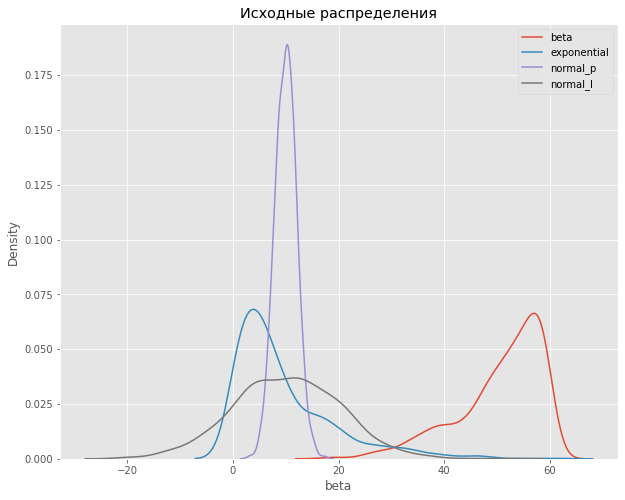

In [268]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df_st['beta'], ax=ax1, label ='beta')
sns.kdeplot(df_st['exponential'], ax=ax1, label ='exponential')
sns.kdeplot(df_st['normal_p'], ax=ax1, label ='normal_p')
sns.kdeplot(df_st['normal_l'], ax=ax1, label ='normal_l')
plt.legend()

Признаки распределены по-разному: смещены влево, вправо, присутствуют отрицательные величины. Попробуем нормализовать их.

In [269]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
df_mm = mm_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После нормализации MinMaxScaler')

sns.kdeplot(df_mm['beta'], ax=ax1)
sns.kdeplot(df_mm['exponential'], ax=ax1)
sns.kdeplot(df_mm['normal_p'], ax=ax1)
sns.kdeplot(df_mm['normal_l'], ax=ax1)

ValueError: could not convert string to float: "[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

In [270]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# копируем исходный датасет
df_s = s_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после StandardScaler')

sns.kdeplot(df_s['beta'], ax=ax1)
sns.kdeplot(df_s['exponential'], ax=ax1)
sns.kdeplot(df_s['normal_p'], ax=ax1)
sns.kdeplot(df_s['normal_l'], ax=ax1)

ValueError: could not convert string to float: "[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

In [271]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [272]:
df_1.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'country_Italy',
       'country_Netherlands', 'country_Spain', 'country_United Kingdom',
       'country_France', 'country_Austria', 'city_Milan', 'city_Amsterdam',
       'city_Barcelona', 'city_London', 'city_Paris', 'city_Vienna', 'month',
       'year', 'new_negative_review', 'new_positive_review', 'Leisure_trip',
       'Mobile_submit', 'Couple', 'Solo_traveler', 'Business_trip', 'Group',
       'Family_young_children', 'Double_Room', 'Standard_Double_Room',
       'Superior_Double_Room', 'Family_older_children'],
      dtype='object')

In [273]:
# непрерывные признаки
num_cols = [
     'additional_number_of_scoring', 
     'lat',
     'lng',
     'average_score',
     'review_total_negative_word_counts', 
     'total_number_of_reviews', 
     'review_total_positive_word_counts',
     'total_number_of_reviews_reviewer_has_given',
     'days_since_review',
     'sample',
     'reviewer_score',
     'new_negative_review',
     'new_positive_review',
     'Mobile_submit',
     ] 

# категориальные признаки
cat_cols = ['country_Italy',
     'country_Spain',
     'country_United Kingdom', 
     'country_France',
     'country_Austria',
     'city_Milan', 
     'city_Amsterdam',
     'city_Barcelona',
     'city_London',
     'city_Paris',
     'city_Vienna',
     'month',
     'year',
     'Leisure_trip',
     'Couple',
     #'1_night ',
     #'2_night',
     'Solo_traveler',
     #'3_night',
     'Business_trip',
     'Group',
     'Family_young_children',
     #'4_nights',
     'Double_Room',
     'Standard_Double_Room',
     'Superior_Double_Room',
     'Family_older_children'  
            ]

# 4. Анализ мультиколлинеарности

In [274]:
df_2=df_1.copy()

In [275]:
def show_corr_heatmap(columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = df_2[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

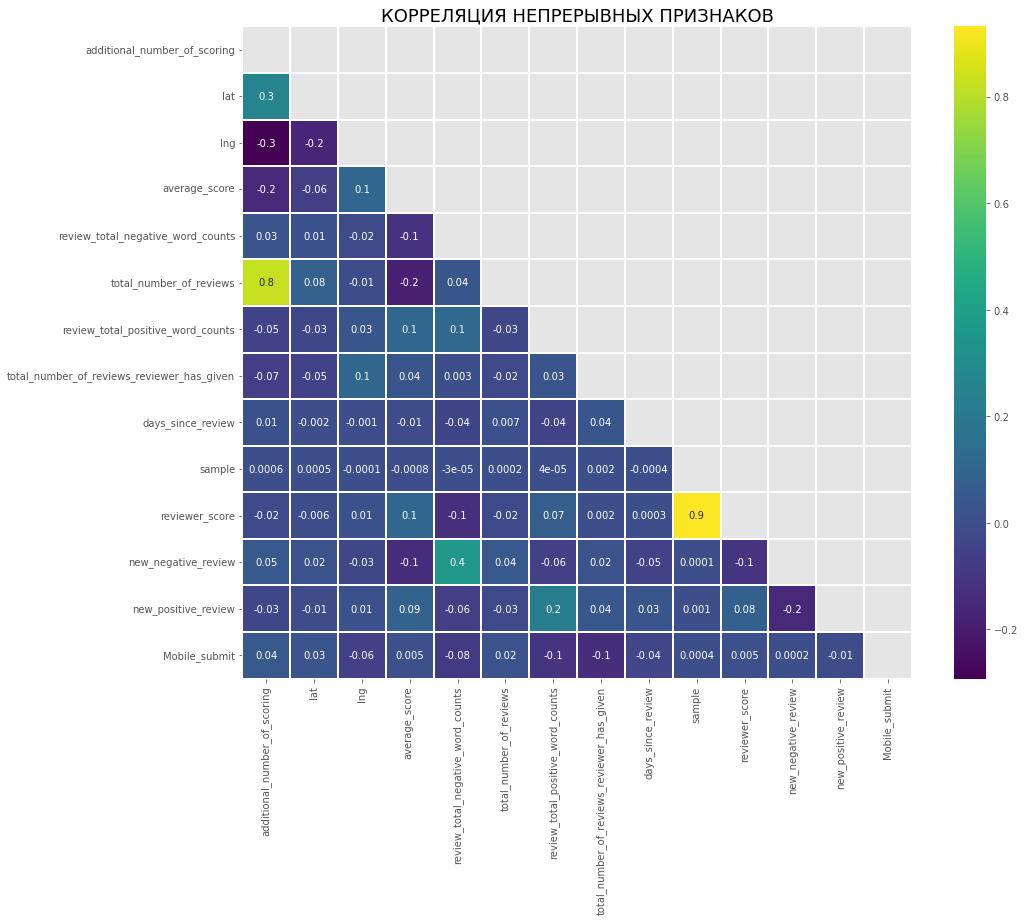

In [276]:
#строю диаграмму для непрерывных признаков:
show_corr_heatmap(num_cols, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', method='pearson');

In [277]:
# Удаляю 2 признака, которые могут привести к мультиколлинеарности
df_2.drop(['total_number_of_reviews'], axis = 1, inplace=True)
df_2.drop(['additional_number_of_scoring'], axis = 1, inplace=True)

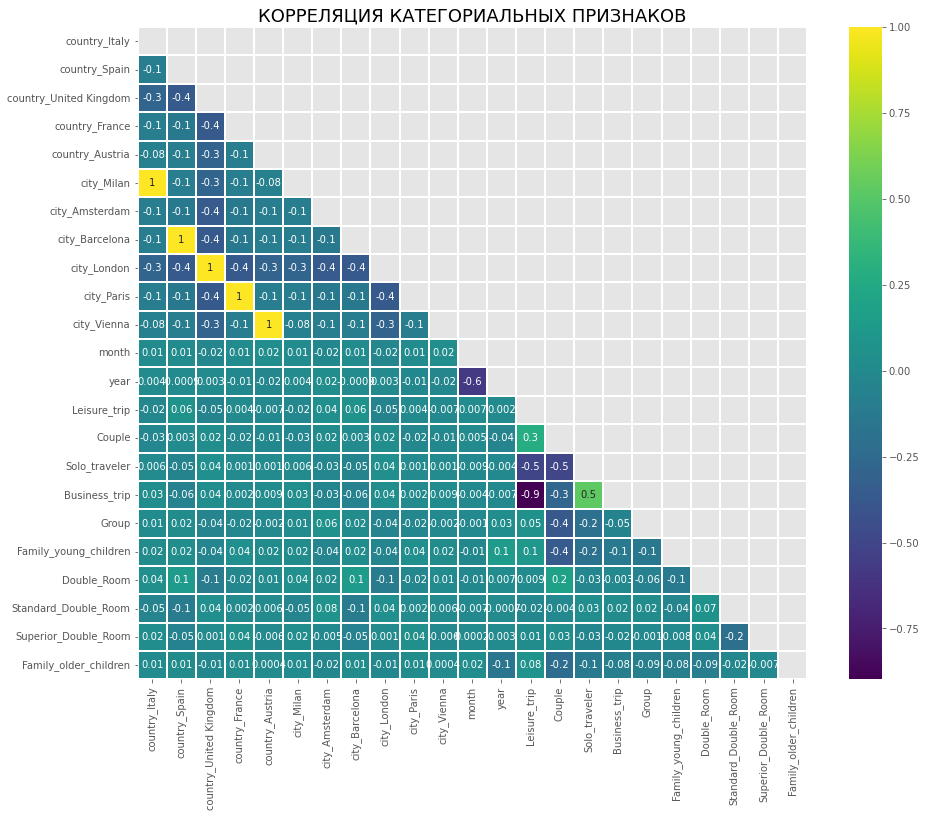

In [278]:
# строю диаграмму для категориальных признаков:
show_corr_heatmap(
    cat_cols, 
    'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ', 
    method='spearman'
);

In [279]:
# Удаляю признаки, которые могут привести к мультиколлинеарности
df_2.drop(['city_Milan'], axis = 1, inplace=True)
df_2.drop(['city_Barcelona'], axis = 1, inplace=True)
df_2.drop(['city_London'], axis = 1, inplace=True)
df_2.drop(['city_Paris'], axis = 1, inplace=True)
df_2.drop(['city_Vienna'], axis = 1, inplace=True)
df_2.drop(['Business_trip'], axis = 1, inplace=True)

print(f'Текущее получившееся количество признаков: {len(df_2.columns)}')
print('(включая столбец "Sample" и целевой столбец)')

Текущее получившееся количество признаков: 30
(включая столбец "Sample" и целевой столбец)


# 5. Оценка значимости признаков

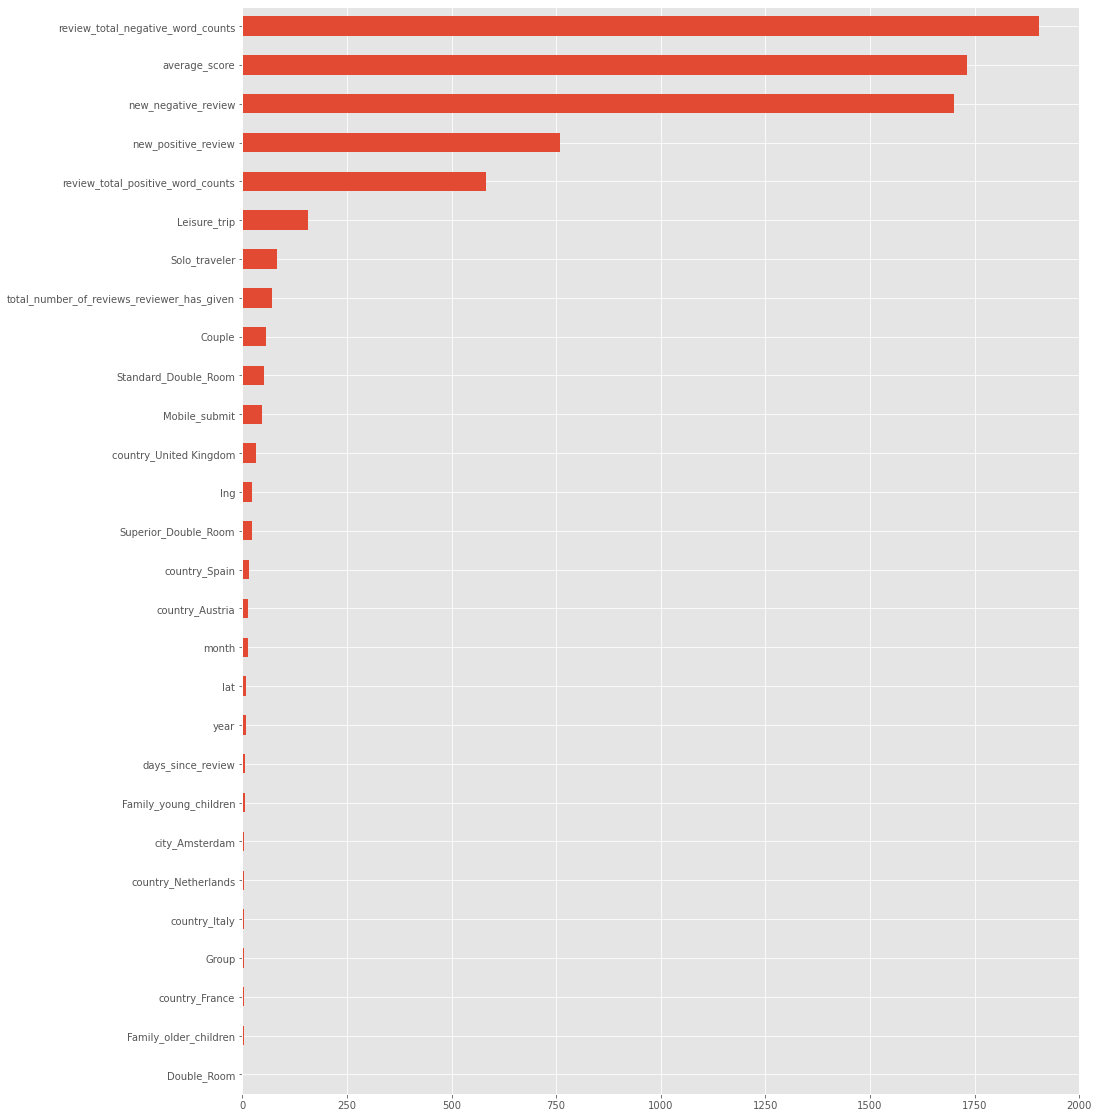

In [281]:
from sklearn.feature_selection import f_classif
y = df_2.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = df_2.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh');

In [283]:
# Удаляю признаки, которые практически не влияют на обучение
drop_columns = ['Double_Room', 'Family_older_children', 'country_France', 'Group',
               'country_Italy', 'country_Netherlands', 'city_Amsterdam',
               'Family_young_children', 'days_since_review', 'year', 'lat',
              ]


df_2.drop(drop_columns, axis = 1, inplace=True)

print(f'Итоговое получившееся количество признаков: {len(df_2.columns)}')

KeyError: "['Double_Room' 'Family_older_children' 'country_France' 'Group'\n 'country_Italy' 'country_Netherlands' 'city_Amsterdam'\n 'Family_young_children' 'days_since_review' 'year' 'lat'] not found in axis"

# 6. Обучение модели

In [284]:
# Теперь выделим тестовую часть
train_data = df_2.query('sample == 1').drop(['sample'], axis=1)
test_data = df_2.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [285]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [286]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 18), (386803, 18), (386803, 17), (309442, 17), (77361, 17))

In [288]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [289]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


In [292]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
from sklearn import metrics
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13729734356575854


<AxesSubplot:>

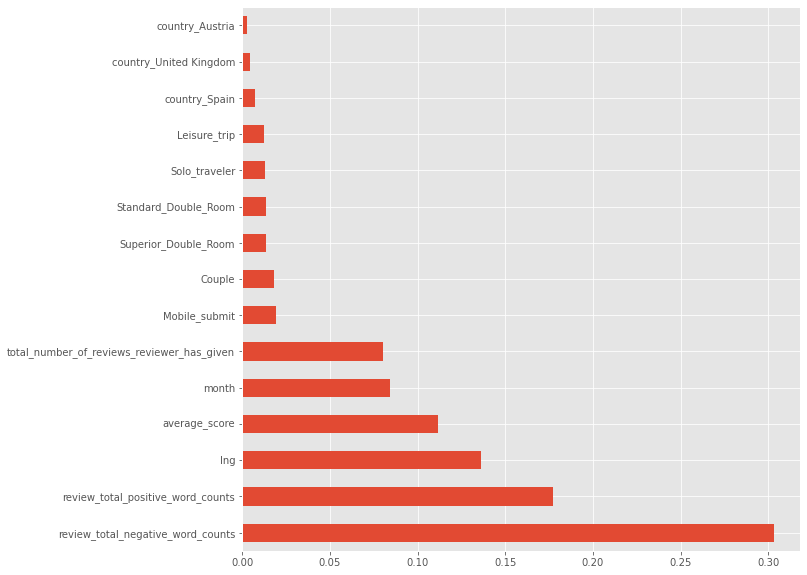

In [293]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [294]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lng,reviewer_score,country_Spain,country_United Kingdom,country_Austria,month,new_negative_review,new_positive_review,Leisure_trip,Mobile_submit,Couple,Solo_traveler,Standard_Double_Room,Superior_Double_Room
92316,8.6,11,0,1,4.875960,0.0,0,0,0,1,1,0,1,1,1,0,0,0
95086,7.5,19,46,1,2.394540,0.0,0,0,0,4,1,1,0,1,0,0,1,0
95201,8.8,0,18,2,-0.283526,0.0,0,1,0,3,0,1,1,0,0,0,0,0
16103,8.9,0,53,2,16.367105,0.0,0,0,1,1,0,1,1,0,1,0,0,0
84543,9.6,0,7,2,-0.131138,0.0,0,1,0,9,0,1,1,1,1,0,0,0
39922,8.4,0,3,6,-0.116009,0.0,0,1,0,11,0,1,0,0,1,0,0,1
70113,8.5,42,36,12,4.881302,0.0,0,0,0,10,1,1,1,0,0,0,0,0
63479,8.3,92,21,7,2.172113,0.0,1,0,0,5,1,1,1,1,1,0,0,0
114175,8.7,16,51,1,-0.137687,0.0,0,1,0,11,1,1,1,1,0,0,0,0
72489,7.6,10,29,9,2.142799,0.0,1,0,0,3,1,1,0,0,0,1,0,0


In [295]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [296]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [297]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


In [298]:
predict_submission

array([8.634, 8.082, 8.186, ..., 7.94 , 9.758, 6.515])

In [299]:
list(sample_submission)

['reviewer_score', 'id']

In [300]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.634,488440
1,8.082,274649
2,8.186,374688
3,9.639,404352
4,9.667,451596
5,8.574,302161
6,6.059,317079
7,7.397,13963
8,8.661,159785
9,8.270,195089
